## Churn Risk Classification
This is a churn risk classifier built using a sample data set of 50K records from a ride sharing service. Predicting users that have a high churn risk enables the business to bucket these users separately for special promotional incentives, allocation of client service resources, etc to drive customer reengagement and limit churn activity.

[Loading and Cleaning the Data](#load_clean)<br> 
[Exploratory Data Analysis](#eda)<br> 
[Model Training](#training)<br> 
[Model Selection](#selection)<br> 
[Hyperparameter Tuning](#tuning)

<a id='load_clean'></a>

### Loading and Cleaning the Data

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [20]:
data = pd.read_csv('data/churn.csv')

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
luxury_car_user           50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [22]:
data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [23]:
#converting the date columns to datetime format
data.last_trip_date = pd.to_datetime(data.last_trip_date, format = '%Y-%m-%d')
data.signup_date = pd.to_datetime(data.signup_date, format = '%Y-%m-%d')
data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
luxury_car_user           50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [25]:
#defining churn as any user who hasn't used service in past month
data['churn'] = data.last_trip_date < '2014-06-01'

In [26]:
data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,False
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,True
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,True
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,False
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,True


In [29]:
data.churn.value_counts()/float(len(data.churn))

True     0.62392
False    0.37608
Name: churn, dtype: float64

nearly 2/3 of our users have churned by our definition

In [30]:
#replacing boolean churn value with 1/0
data.churn = data['churn'].astype(int, inplace=True)

In [31]:
data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,0
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,1
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,1
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,1


In [32]:
#a handful of records don't include a phone value.  Addding a placeholder here.
data.phone = data.phone.fillna('empty_phone')

In [33]:
#checking the phone values
data.phone.value_counts()

iPhone         34582
Android        15022
empty_phone      396
Name: phone, dtype: int64

In [34]:
#creating dummies for phone and city categorical vars
data.city = data.city.astype("category")
data.phone = data.phone.astype('category')

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null category
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null category
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
luxury_car_user           50000 non-null bool
weekday_pct               50000 non-null float64
churn                     50000 non-null int64
dtypes: bool(1), category(2), datetime64[ns](2), float64(6), int64(2)
memory usage: 4.0 MB


### What to do about missing values?
-the ratings variables need to be removed, imputed with some value, or binned separately as 'empty'

-the first two options should be considered when the values are missing at random, otherwise we should bin

-to determine whether the missing values are random we can observe whether the missing values have an effect on churn by comparing the churn rate of users who have missing values v those who do not.  

#### Some info on the scs function I'll use to compare the groups of records....

    scipy.stats.ttest_ind(a, b, axis=0, equal_var=True)[source]
    Calculates the T-test for the means of TWO INDEPENDENT samples of scores.

    This is a two-sided test for the null hypothesis that 2 independent samples have identical average (expected) 
    values. This test assumes that the populations have identical variances.

In [36]:
#writing a function to run t-test between groups that do and don't posess a particular condition
#used to determine whether the condition affects churn rate.  If not, we can either drop records with missing vals 
#or impute a value.  Otherwise, we should retain the records and bin them separately

import scipy.stats as scs

def t_test(feature, condition):
    '''
    INPUT feature (a pandas Series): the column of interest
    INPUT condition (boolean): condition to t-test by
    OUTPUT
    '''
    #test takes in a Series and applies the condition: the churn column where phone is null
    #compares this sample to the opposite: churn column where phone IS NOT null
    #compares the means of each sample to one another (mean of array of 1s/0s)
    #runs t-test 

    ttest = scs.ttest_ind(feature[condition], feature[-condition])
    print '***t-test for difference in means***'
    print 'user count with condition: {}, user count without condition: {}'\
        .format(len(feature[condition]), len(feature[-condition]))
    print 'mean with condition: {}, mean without condition: {}'\
        .format(feature[condition].mean(), feature[-condition].mean())
    print 't statistic: {}'.format(ttest.statistic, 4)
    print 'p-value: {}'.format(ttest.pvalue)
    
    

In [37]:
# Measure the effect of empty phone values
t_test(data['churn'], data['phone'] == 'empty_phone')

***t-test for difference in means***
user count with condition: 396, user count without condition: 49604
mean with condition: 0.664141414141, mean without condition: 0.623598903314
t statistic: 1.65893845728
p-value: 0.0971344664588


This condition does not generate a statistically significant difference in churn rate.  we can therefore drop the records with missing phone

In [38]:
data = data[data['phone'] != 'empty_phone']

In [39]:
#verifying dropped records
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  49604 non-null float64
avg_rating_by_driver      49406 non-null float64
avg_rating_of_driver      41578 non-null float64
avg_surge                 49604 non-null float64
city                      49604 non-null category
last_trip_date            49604 non-null datetime64[ns]
phone                     49604 non-null category
signup_date               49604 non-null datetime64[ns]
surge_pct                 49604 non-null float64
trips_in_first_30_days    49604 non-null int64
luxury_car_user           49604 non-null bool
weekday_pct               49604 non-null float64
churn                     49604 non-null int64
dtypes: bool(1), category(2), datetime64[ns](2), float64(6), int64(2)
memory usage: 4.3 MB


In [40]:
#Measure the effect of missing avg_rating_by_driver values
t_test(data['churn'], data['avg_rating_by_driver'].isnull())

***t-test for difference in means***
user count with condition: 198, user count without condition: 49406
mean with condition: 0.818181818182, mean without condition: 0.622819090799
t statistic: 5.6644709906
p-value: 1.48293067402e-08


In [41]:
#Measure the effect of missing avg_rating_of_driver values
t_test(data['churn'], data['avg_rating_of_driver'].isnull())

***t-test for difference in means***
user count with condition: 8026, user count without condition: 41578
mean with condition: 0.797906802891, mean without condition: 0.589951416615
t statistic: 35.6534139171
p-value: 6.34574724075e-275


These conditions seem to influence churn.  We should therefore retain the records with missing values by bucketing them separately.

In [44]:
data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,0
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,1
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,1
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,1


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  49604 non-null float64
avg_rating_by_driver      49406 non-null float64
avg_rating_of_driver      41578 non-null float64
avg_surge                 49604 non-null float64
city                      49604 non-null category
last_trip_date            49604 non-null datetime64[ns]
phone                     49604 non-null category
signup_date               49604 non-null datetime64[ns]
surge_pct                 49604 non-null float64
trips_in_first_30_days    49604 non-null int64
luxury_car_user           49604 non-null bool
weekday_pct               49604 non-null float64
churn                     49604 non-null int64
dtypes: bool(1), category(2), datetime64[ns](2), float64(6), int64(2)
memory usage: 4.3 MB


How should we bin these two features? The distribution below shows a significant left skew and many records receiving ratings of 5. We can bin the full long tail together to represent subpar reviews, bin the 5s, and potentially create a couple more bins to capture the mid range (in this case, maybe 4-4.99 range).

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10226a1d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x116c04a90>], dtype=object)

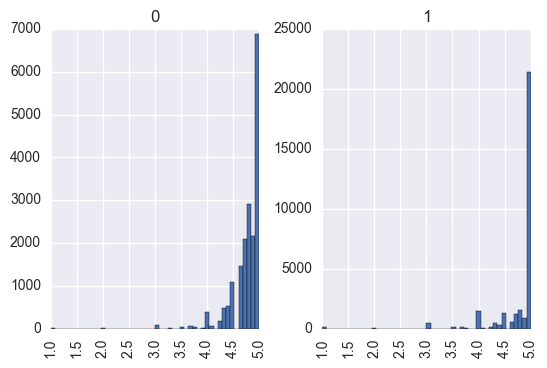

In [46]:
data.avg_rating_by_driver.hist(bins=50, histtype='bar', by=data.churn, stacked=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x112c88550>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x112c9b090>], dtype=object)

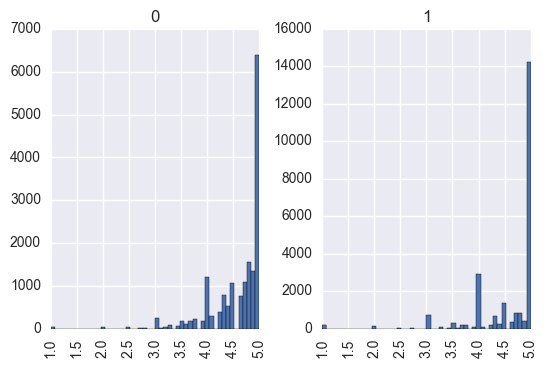

In [47]:
data.avg_rating_of_driver.hist(bins=50, histtype='bar', by=data.churn, stacked=True)

In [48]:
def add_binned_ratings(df, old_col, new_col):
    '''
    Add column for binned ratings.
    
    INPUT:
    - df (full dataframe)
    - old_col (str): column name of average ratings
    - new_col (str): new column name for binned average ratings
    OUTPUT:
    - new dataframe
    '''
    df[new_col] = pd.cut(df[old_col].copy(), bins=[0., 3.99, 4.99, 5],
                            include_lowest=True, right=True)
    df[new_col].cat.add_categories('Missing', inplace=True)
    df[new_col].fillna('Missing', inplace=True)                        
    return df

data = add_binned_ratings(data, 'avg_rating_by_driver', 'bin_avg_rating_by_driver')
data = add_binned_ratings(data, 'avg_rating_of_driver', 'bin_avg_rating_of_driver')

In [49]:
data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn,bin_avg_rating_by_driver,bin_avg_rating_of_driver
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,0,"(4.99, 5]","(3.99, 4.99]"
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,1,"(4.99, 5]","(4.99, 5]"
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,1,"(4.99, 5]","(3.99, 4.99]"
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,0,"(3.99, 4.99]","(3.99, 4.99]"
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,1,"(3.99, 4.99]","(3.99, 4.99]"


I've chosen to create 4 bins for each: missing, 5's, 0-3s (left skew), and 4s

In [50]:
data.bin_avg_rating_by_driver.value_counts()

(4.99, 5]       28271
(3.99, 4.99]    19573
[0, 3.99]        1562
Missing           198
Name: bin_avg_rating_by_driver, dtype: int64

In [51]:
data.bin_avg_rating_of_driver.value_counts()

(4.99, 5]       20625
(3.99, 4.99]    17165
Missing          8026
[0, 3.99]        3788
Name: bin_avg_rating_of_driver, dtype: int64

In [52]:
data.drop(['avg_rating_by_driver','avg_rating_of_driver'], axis=1, inplace=True)

In [53]:
data.head()

,avg_dist,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn,bin_avg_rating_by_driver,bin_avg_rating_of_driver
0,3.67,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,0,"(4.99, 5]","(3.99, 4.99]"
1,8.26,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,1,"(4.99, 5]","(4.99, 5]"
2,0.77,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,1,"(4.99, 5]","(3.99, 4.99]"
3,2.36,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,0,"(3.99, 4.99]","(3.99, 4.99]"
4,3.13,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,1,"(3.99, 4.99]","(3.99, 4.99]"


<a id='eda'></a>

### EDA

#### Hypotheses
* price matters: avg_surge is correlated with churn, surge_pct correlated with churn
* high ratings matter: higher bin negatively correlates with churn 
* high usage matters: avg_dist * trips_in_first_30_days as proxy for total distance ridden, negatively correlated with 
  churn
* phone matters: iPhone users have better experiences with app than Android users bc of phone software fragmentation
* high weekday usage matters: high weekday_pct might be an indicator that one is reliant on a ride share service for 
  their commute, therefore less likely to churn
* initial usage habits matter: trips_in_first_30_days is negatievly correlated with churn
* lack of ratings by user could indicate underutilization of service features, low level utility
* lack of ratings by driver could indicate perception of poor customer experience

In [236]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_dist,49604.0,5.785418,5.669709,0.0,2.42,3.88,6.93,160.96
avg_surge,49604.0,1.074991,0.222666,1.0,1.00,1.00,1.05,8.00
surge_pct,49604.0,8.875314,19.989018,0.0,0.00,0.00,8.70,100.00
trips_in_first_30_days,49604.0,2.277256,3.793300,0.0,0.00,1.00,3.00,125.00
weekday_pct,49604.0,60.883832,37.086239,0.0,33.30,66.70,100.00,100.00
churn,49604.0,0.623599,0.484487,0.0,0.00,1.00,1.00,1.00


In [237]:
data.groupby(['churn']).mean()

,avg_dist,avg_surge,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
churn,,,,,,
0,5.113930,1.073834,9.165615,3.304804,0.503990,61.344208
1,6.190725,1.075689,8.700091,1.657033,0.297482,60.605952


In [238]:
data.groupby(['churn']).describe().T

churn                         0                                           \
                          count       mean        std  min    25%    50%   
avg_dist                18671.0   5.113930   4.617779  0.0   2.56   3.73   
avg_surge               18671.0   1.073834   0.162905  1.0   1.00   1.00   
surge_pct               18671.0   9.165615  15.599652  0.0   0.00   0.00   
trips_in_first_30_days  18671.0   3.304804   4.985057  0.0   0.00   2.00   
weekday_pct             18671.0  61.344208  29.512875  0.0  44.40  64.30   

churn                                        1                             \
                          75%     max    count       mean        std  min   
avg_dist                 5.89  160.96  30933.0   6.190725   6.184010  0.0   
avg_surge                1.09    4.50  30933.0   1.075689   0.251969  1.0   
surge_pct               13.30  100.00  30933.0   8.700091  22.221133  0.0   
trips_in_first_30_days   4.00  125.00  30933.0   1.657033   2.655767  0.0   
weekday_pct             84.60  100.00  30933.0  60.605952  40.983689  0.0   

churn                                                 
                          25%    50%     75%     max  
avg_dist                 2.31   4.03    7.78   79.69  
avg_surge                1.00   1.00    1.00    8.00  
surge_pct                0.00   0.00    0.00  100.00  
trips_in_first_30_days   0.00   1.00    2.00   73.00  
weekday_pct             16.70  69.20  100.00  100.00

* Surprisingly, churners have a higher average distance mean and median, higher distance in the 75th percentile. Not 
  surprisingly, they take fewer trips in the first 30 days on average (mean and median). Comparing medians of the 
  first two groups, churners ride on 1x in the first 30 whereas non-churners ride 2x.  There could be an action here - 
  getting users to ride 2x via an incentive program. 

* Churners seem much more likely to be weekday-only riders. In fact, this looks to be a sizable group: of the 31K 
  churners, a full 1/4 of them are weekday only.  May be worth looking at these users as fundamentaly different than 
  the rest.

* Surge pct doesn't seem to have a big impact.  Non-churners actually have a higher rate of surge_pct. 


In [239]:
pd.crosstab(data.churn, data.phone).apply(lambda r: r/r.sum(), axis=0)

phone,Android,empty_phone,iPhone
churn,,,
0,0.209426,NaN,0.448933
1,0.790574,NaN,0.551067


iphone users much less likely to churn than Android users

In [240]:
pd.set_option('display.max_columns', 500)
data[(data.phone == ['iPhone'])|(data.phone =='Android')].groupby(['churn','phone']).describe().T

churn                        0                                             \
phone                  Android                                              
                         count       mean        std  min      25%    50%   
avg_dist                3146.0   5.165420   5.163366  0.0   2.6725   3.84   
avg_surge               3146.0   1.062508   0.151789  1.0   1.0000   1.00   
surge_pct               3146.0   8.181659  15.406604  0.0   0.0000   0.00   
trips_in_first_30_days  3146.0   2.985696   4.604841  0.0   0.0000   2.00   
weekday_pct             3146.0  60.739479  31.011584  0.0  42.9000  65.20   

churn                                                                       \
phone                                    iPhone                              
                           75%     max    count       mean        std  min   
avg_dist                 5.940  160.96  15525.0   5.103496   4.499278  0.0   
avg_surge                1.070    4.25  15525.0   1.076129   0.164976  1.0   
surge_pct               11.100  100.00  15525.0   9.365005  15.631427  0.0   
trips_in_first_30_days   4.000   47.00  15525.0   3.369469   5.056310  0.0   
weekday_pct             86.075  100.00  15525.0  61.466750  29.199318  0.0   

churn                                                     1             \
phone                                               Android              
                          25%   50%    75%     max    count       mean   
avg_dist                 2.53   3.7   5.88   79.34  11876.0   6.194195   
avg_surge                1.00   1.0   1.10    4.50  11876.0   1.074158   
surge_pct                0.00   0.0  14.00  100.00  11876.0   8.635433   
trips_in_first_30_days   0.00   2.0   4.00  125.00  11876.0   1.656618   
weekday_pct             44.40  64.0  84.20  100.00  11876.0  60.314121   

churn                                                                          \
phone                                                                  iPhone   
                              std  min    25%    50%     75%     max    count   
avg_dist                 6.084339  0.0  2.370   4.09    7.76   63.15  19057.0   
avg_surge                0.246802  1.0  1.000   1.00    1.00    5.00  19057.0   
surge_pct               22.479721  0.0  0.000   0.00    0.00  100.00  19057.0   
trips_in_first_30_days   2.596349  0.0  0.000   1.00    2.00   73.00  19057.0   
weekday_pct             41.193738  0.0  9.775  68.90  100.00  100.00  19057.0   

churn                                                                           
phone                                                                           
                             mean        std  min    25%    50%    75%     max  
avg_dist                 6.188563   6.245478  0.0   2.28   3.99    7.8   79.69  
avg_surge                1.076643   0.255138  1.0   1.00   1.00    1.0    8.00  
surge_pct                8.740384  22.058948  0.0   0.00   0.00    0.0  100.00  
trips_in_first_30_days   1.657291   2.692200  0.0   0.00   1.00    2.0   56.00  
weekday_pct             60.787816  40.852273  0.0  20.00  69.60  100.0  100.00

In [241]:
pd.crosstab(data.churn, data.luxury_car_user).apply(lambda r: r/r.sum(), axis=0)

luxury_car_user,False,True
churn,,
0,0.298819,0.505588
1,0.701181,0.494412


luxury car users much less likely to churn

In [242]:
pd.crosstab(data.churn, data.city).apply(lambda r: r/r.sum(), axis=0)

city,Astapor,King's Landing,Winterfell
churn,,,
0,0.255773,0.628353,0.352346
1,0.744227,0.371647,0.647654


city looks to be very significant

In [243]:
pd.crosstab(data.churn, data.bin_avg_rating_by_driver).apply(lambda r: r/r.sum(), axis=0)

bin_avg_rating_by_driver,"[0, 3.99]","(3.99, 4.99]","(4.99, 5]",Missing
churn,,,,
0,0.211268,0.583457,0.243536,0.181818
1,0.788732,0.416543,0.756464,0.818182


weird distributions here: poor and high ratings more likely to churn than mid-range ratings.  Missing very high

In [244]:
pd.crosstab(data.churn, data.bin_avg_rating_of_driver).apply(lambda r: r/r.sum(), axis=0)

bin_avg_rating_of_driver,"[0, 3.99]","(3.99, 4.99]","(4.99, 5]",Missing
churn,,,,
0,0.420011,0.528168,0.309915,0.202093
1,0.579989,0.471832,0.690085,0.797907


same strange distributions - poor average experiences less likely to churn than good average experiences. missing intuitively the highest 

In [245]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                    49604 non-null float64
avg_surge                   49604 non-null float64
city                        49604 non-null category
last_trip_date              49604 non-null datetime64[ns]
phone                       49604 non-null category
signup_date                 49604 non-null datetime64[ns]
surge_pct                   49604 non-null float64
trips_in_first_30_days      49604 non-null int64
luxury_car_user             49604 non-null bool
weekday_pct                 49604 non-null float64
churn                       49604 non-null int64
bin_avg_rating_by_driver    49604 non-null category
bin_avg_rating_of_driver    49604 non-null category
dtypes: bool(1), category(4), datetime64[ns](2), float64(4), int64(2)
memory usage: 3.6 MB


I now need to convert the categorical variables into dummies...

In [246]:
data_phone = pd.get_dummies(data.phone)

data.bin_avg_rating_by_driver = map(lambda x: 'bin_by_driver_' + str(x), data.bin_avg_rating_by_driver)
data_bin_avg_rating_by_driver = pd.get_dummies(data.bin_avg_rating_by_driver)

data.bin_avg_rating_of_driver = map(lambda x: 'bin_of_driver_' + str(x), data.bin_avg_rating_of_driver)
data_bin_avg_rating_of_driver = pd.get_dummies(data.bin_avg_rating_of_driver)


data_city = pd.get_dummies(data.city)

In [247]:
data = pd.concat([data, data_phone, data_bin_avg_rating_by_driver,data_bin_avg_rating_of_driver,data_city ], axis = 1)
data = data.drop(['phone','bin_avg_rating_by_driver','bin_avg_rating_of_driver','city'], 1)

In [248]:
data.head()

,avg_dist,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn,Android,empty_phone,iPhone,"bin_by_driver_(3.99, 4.99]","bin_by_driver_(4.99, 5]",bin_by_driver_Missing,"bin_by_driver_[0, 3.99]","bin_of_driver_(3.99, 4.99]","bin_of_driver_(4.99, 5]",bin_of_driver_Missing,"bin_of_driver_[0, 3.99]",Astapor,King's Landing,Winterfell
0,3.67,1.10,2014-06-17,2014-01-25,15.4,4,True,46.2,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,8.26,1.00,2014-05-05,2014-01-29,0.0,0,False,50.0,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.77,1.00,2014-01-07,2014-01-06,0.0,3,False,100.0,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2.36,1.14,2014-06-29,2014-01-10,20.0,9,True,80.0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,3.13,1.19,2014-03-15,2014-01-27,11.8,14,False,82.4,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [249]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 23 columns):
avg_dist                      49604 non-null float64
avg_surge                     49604 non-null float64
last_trip_date                49604 non-null datetime64[ns]
signup_date                   49604 non-null datetime64[ns]
surge_pct                     49604 non-null float64
trips_in_first_30_days        49604 non-null int64
luxury_car_user               49604 non-null bool
weekday_pct                   49604 non-null float64
churn                         49604 non-null int64
Android                       49604 non-null float64
empty_phone                   49604 non-null float64
iPhone                        49604 non-null float64
bin_by_driver_(3.99, 4.99]    49604 non-null float64
bin_by_driver_(4.99, 5]       49604 non-null float64
bin_by_driver_Missing         49604 non-null float64
bin_by_driver_[0, 3.99]       49604 non-null float64
bin_of_driver_(3.99, 4.99]    49604 

In [250]:
#still need to get ride of dates...
data = data.drop(['last_trip_date','signup_date'],axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 21 columns):
avg_dist                      49604 non-null float64
avg_surge                     49604 non-null float64
surge_pct                     49604 non-null float64
trips_in_first_30_days        49604 non-null int64
luxury_car_user               49604 non-null bool
weekday_pct                   49604 non-null float64
churn                         49604 non-null int64
Android                       49604 non-null float64
empty_phone                   49604 non-null float64
iPhone                        49604 non-null float64
bin_by_driver_(3.99, 4.99]    49604 non-null float64
bin_by_driver_(4.99, 5]       49604 non-null float64
bin_by_driver_Missing         49604 non-null float64
bin_by_driver_[0, 3.99]       49604 non-null float64
bin_of_driver_(3.99, 4.99]    49604 non-null float64
bin_of_driver_(4.99, 5]       49604 non-null float64
bin_of_driver_Missing         49604 non-null float

In [251]:
#verifying that my model input data is all numeric and nothing crazy standing out...
data.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_dist,49604.0,5.785418,5.669709,0.0,2.42,3.88,6.93,160.96
avg_surge,49604.0,1.074991,0.222666,1.0,1.00,1.00,1.05,8.00
surge_pct,49604.0,8.875314,19.989018,0.0,0.00,0.00,8.70,100.00
trips_in_first_30_days,49604.0,2.277256,3.793300,0.0,0.00,1.00,3.00,125.00
weekday_pct,49604.0,60.883832,37.086239,0.0,33.30,66.70,100.00,100.00
churn,49604.0,0.623599,0.484487,0.0,0.00,1.00,1.00,1.00
Android,49604.0,0.302838,0.459491,0.0,0.00,0.00,1.00,1.00
empty_phone,49604.0,0.000000,0.000000,0.0,0.00,0.00,0.00,0.00
iPhone,49604.0,0.697162,0.459491,0.0,0.00,1.00,1.00,1.00
"bin_by_driver_(3.99, 4.99]",49604.0,0.394585,0.488766,0.0,0.00,0.00,1.00,1.00


Time to build some crappy models and visualizations for evaluation

In [252]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split

In [253]:
def roc_curve(probabilities, labels):
    '''
    INPUT: numpy array, numpy array
    OUTPUT: list, list, list

    Take a numpy array of the predicted probabilities and a numpy array of the
    true labels.
    Return the True Positive Rates, False Positive Rates and Thresholds for the
    ROC curve.
    '''

    thresholds = np.sort(probabilities)

    tprs = []
    fprs = []
    
    #true conditions
    num_positive_cases = sum(labels)
    num_negative_cases = len(labels) - num_positive_cases

    
    
    #go through each threshold level (ie, each predicted probability) and capture the true pos rate and false pos rate
    for threshold in thresholds:
        # With this threshold, give the prediction of each instance
        predicted_positive = probabilities >= threshold
        # Calculate the number of correctly predicted positive cases
        true_positives = np.sum(predicted_positive * labels)
        # Calculate the number of incorrectly predicted positive cases
        false_positives = np.sum(predicted_positive) - true_positives
        # Calculate the True Positive Rate
        tpr = true_positives / float(num_positive_cases)
        # Calculate the False Positive Rate
        fpr = false_positives / float(num_negative_cases)

        fprs.append(fpr)
        tprs.append(tpr)
    
    return tprs, fprs, thresholds.tolist()


#takes in the predicted probs and labels, calls the previous function and generates the ROC

def plot_roc(probs, y_true, title, xlabel, ylabel):
    # ROC
    tpr, fpr, thresholds = roc_curve(v_probs, y_test)

    plt.hold(True)
    plt.plot(fpr, tpr)

    # 45 degree line
    xx = np.linspace(0, 1.0, 20)
    plt.plot(xx, xx, color='red')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.show()

In [254]:
#separate the predictors from the dependent var
X = data.copy()
y = X.pop('churn')

In [255]:
#separate training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [257]:
print 'X_train count: {}'.format(len(X_train))
print 'X_test count: {}'.format(len(X_test))
print 'y_train count: {}'.format(len(y_train))
print 'y_test count: {}'.format(len(y_test))

X_train count: 39683
X_test count: 9921
y_train count: 39683
y_test count: 9921


In [258]:
#run log_reg
lr = LogisticRegression(class_weight='auto')
lr.fit(X_train, y_train)

/Users/mdcorey/anaconda2/lib/python2.7/site-packages/sklearn/utils/class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


LogisticRegression(C=1.0, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [259]:
lr.score(X_test,y_test)

0.74468299566575946

The score function returns acuracy of model on test set.  This number must be evaluated in the context of a baseline model.  For example, we know that 62% of our data has churned.  Assuming that the data set is a random sample of the true population, our dumb log-reg model improves on this baseline accuracy by ~19% ((74-62)/62). 

Accuracy is likely the wrong evaluation metric though.  In the case of churn, false positives (incorrectly labeling low churn risk users as high risk) are less harmful than false negatives (incorrectly labeling high churn risk users as low risk) since the costs these errors are drastically different.  

Model evaluation technique will depend on the context of the business problem we are addressing.  For example, if we are trying to classify users based on probability of churn in order to market to these particular users and lower the propensity of churn, this implies a couple things:
   1) there is likely a marketing budget constraint - eg we can only spend x total dollars to address this issue 
   2) we should expect different cost/benefit values for each classification category (TP, FP, TN, FN)  
 
In this case, we should evaluate models using a profit curve and select the model that optimizes overall profit at the constraint point.  This is dependent on creating a confusion matrix with cell costs overlaid. 

If we are only interested in attaining the 'best' predictor, and can assume no value in applying cost/benefits to each classification category, we should use a ROC to evaluate the models and select the model that optimizes 'AUC' (area under the curve) 

There is an inherent tradeoff between true positive rate (aka sensitivity/recall) and false positive rate.  
   TP/(TP + FN) --> true positive rate is true positives divided by total condition positive
   FP/(FP + TN) --> false positive rate is false positives divided by total condition negative

In [263]:
#to generate the ROC curve we need to get the predicted probabilities of the test set...
v_probs = lr.predict_proba(X_test)[:, 1]

In [267]:
#verifying that the number matches that of the test count
len(v_probs)

9921

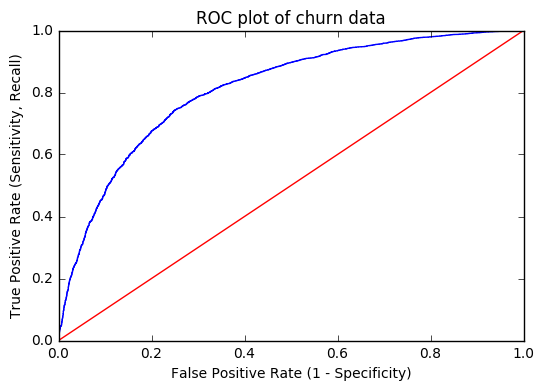

In [268]:
plot_roc(v_probs, y_test, "ROC plot of churn data", 
         "False Positive Rate (1 - Specificity)", "True Positive Rate (Sensitivity, Recall)")


Model Training and Selection

Hyperparameter Tuning